# Basics of Graphs

## Decomposing features (signal) and structure

As we saw in the lesson on Transformers, natural language can also be decomposed to signal and structure. The structure is the order of words, which implies syntax and grammar context. 

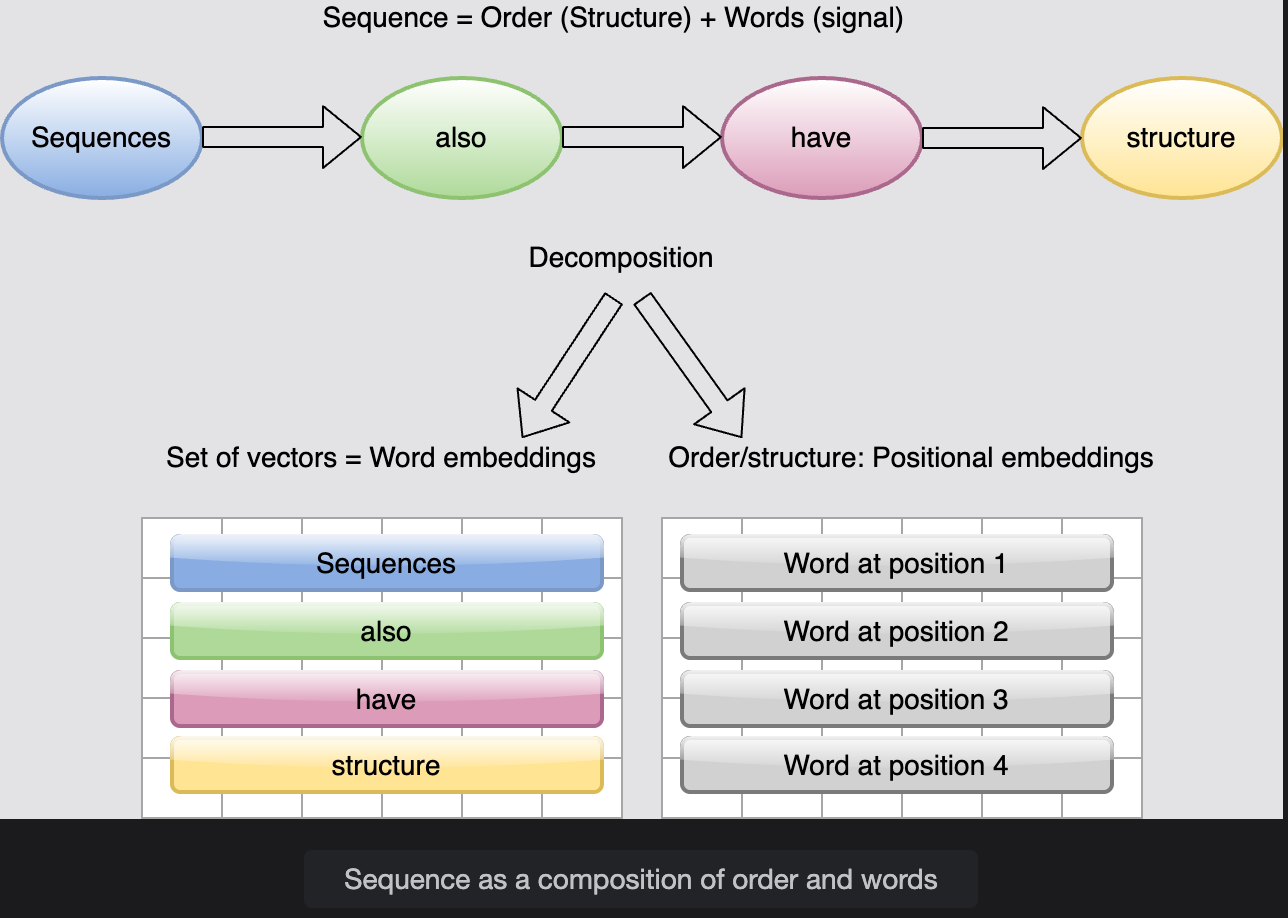

The features will now be a set of word embeddings, and the order will be encoded in the positional embeddings.

Graphs are not any different: they are data with decomposed structure and signal information.

## Real-world signals that we can model with graphs

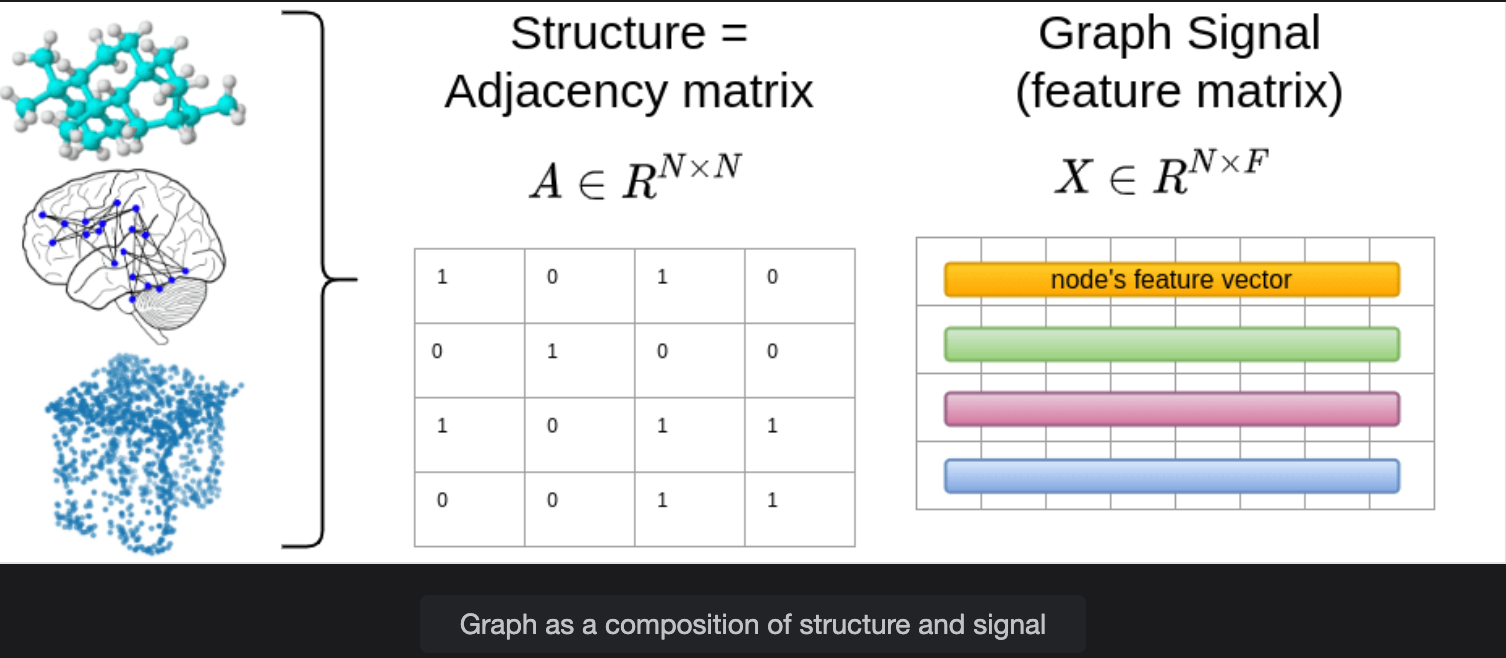

To this end, we can represent brain graphs from functional medical imaging, social networks, point clouds, and even molecules and proteins.

In [6]:
# calculating degree

import torch
#rand binary Adj matrix
a = torch.rand(3,3)
a[a>0.5] = 1
a[a<=0.5] = 0

def calc_degree_matrix(a):
 return torch.diag(a.sum(dim=-1))

d = calc_degree_matrix(a)

print("A:" ,a)
print("D:", d)

A: tensor([[1., 1., 0.],
        [1., 0., 1.],
        [0., 1., 1.]])
D: tensor([[2., 0., 0.],
        [0., 2., 0.],
        [0., 0., 2.]])


## The graph Laplacian

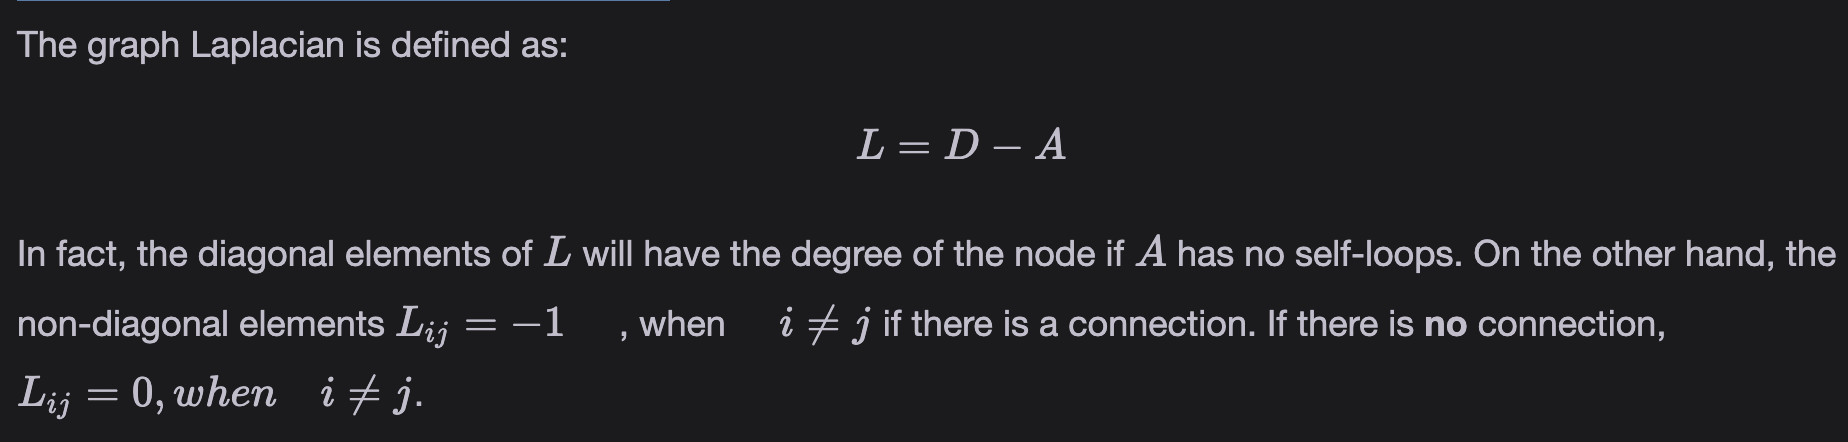

In [7]:
import torch
#rand binary Adj matrix
a = torch.rand(5,5)
a[a>0.5] = 1
a[a<=0.5] = 0

def calc_degree_matrix(a):
 return torch.diag(a.sum(dim=-1))

def create_graph_lapl(a):
 return calc_degree_matrix(a)-a

print("A:", a)
print("L:", create_graph_lapl(a))

A: tensor([[1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0.]])
L: tensor([[ 2., -1., -1.,  0.,  0.],
        [-1.,  3., -1., -1.,  0.],
        [-1., -1.,  3., -1.,  0.],
        [-1., -1.,  0.,  2.,  0.],
        [-1., -1., -1., -1.,  4.]])


However, in graph neural networks, we use its normalized version because nodes have varying connectivity and, as a result, a big range of degree values on D.

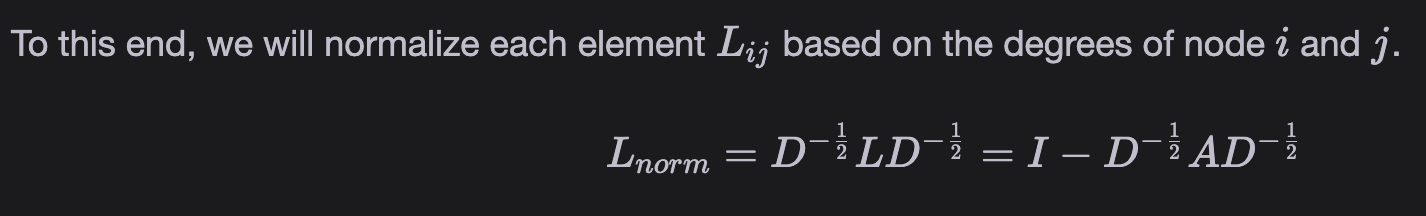

In [8]:
import torch
#rand binary Adj matrix
a = torch.rand(5,5)
a[a>0.5] = 1
a[a<=0.5] = 0


def calc_degree_matrix_norm(a):
 return torch.diag(torch.pow(a.sum(dim=-1),-0.5))

def create_graph_lapl_norm(a):
 size = a.shape[-1]
 D_norm = calc_degree_matrix_norm(a)
 L_norm = torch.ones(size) - (D_norm @ a @ D_norm )
 return L_norm

print("A: ", a)
print("L_norm: ", create_graph_lapl_norm(a))

A:  tensor([[1., 0., 0., 1., 0.],
        [0., 1., 1., 0., 1.],
        [0., 1., 0., 1., 1.],
        [1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 1.]])
L_norm:  tensor([[0.5000, 1.0000, 1.0000, 0.6464, 1.0000],
        [1.0000, 0.6667, 0.6667, 1.0000, 0.4226],
        [1.0000, 0.6667, 1.0000, 0.7113, 0.4226],
        [0.6464, 0.7113, 0.7113, 1.0000, 0.5000],
        [1.0000, 1.0000, 1.0000, 1.0000, 0.0000]])


# 🌐 The Normalized Graph Laplacian ($\mathbf{L}_{\text{norm}}$) in GNNs

The **Normalized Graph Laplacian ($\mathbf{L}_{\text{norm}}$)** is the key operator used in Graph Convolutional Networks (GCNs) to facilitate stable and scaled aggregation of features across the graph.

## 1. Components of the Normalized Graph Laplacian

The core equation for the normalized Laplacian used in GCNs is:

$$\mathbf{L}_{\text{norm}} = \mathbf{D}^{-\frac{1}{2}}(\mathbf{A} + \mathbf{I})\mathbf{D}^{-\frac{1}{2}}$$

| Component | Matrix Type | Role |
| :--- | :--- | :--- |
| $\mathbf{A}$ | Adjacency Matrix | Binary matrix where $\mathbf{A}_{ij}=1$ if node $i$ and node $j$ are connected, and $0$ otherwise. |
| $\mathbf{I}$ | Identity Matrix | Diagonal matrix with ones on the main diagonal. |
| $\mathbf{A} + \mathbf{I}$ | Self-Loop Adjacency | Adds a connection from every node to itself, ensuring a node's features are always included in its own neighborhood aggregation. |
| $\mathbf{D}$ | Degree Matrix | Diagonal matrix where $\mathbf{D}_{ii}$ is the degree (count of neighbors) of node $i$. |
| $\mathbf{D}^{-\frac{1}{2}}$ | Inverse Square Root of Degree Matrix | Used for **normalization**; it scales the features based on how connected each node is. |

---

## 2. Why $\mathbf{A} + \mathbf{I}$ is Used (Adding Self-Connections)

The standard adjacency matrix $\mathbf{A}$ only represents connections between different nodes.

* **$\mathbf{A} + \mathbf{I}$** is used to add **self-loops** to the graph.
* **Effect:** When a GNN layer aggregates features from a node's neighborhood, the self-loop ensures that the node's **own features** are included in the aggregation process alongside its neighbors' features. This is critical because a node's own information is usually the most important part of its new representation.

---

## 3. Why $\mathbf{D}^{-\frac{1}{2}}$ is Used (Normalization)

The terms $\mathbf{D}^{-\frac{1}{2}}$ on both sides are there for **normalization**. This specifically addresses the instability problem associated with aggregating unscaled features.

* **The Problem (Unscaled Aggregation):** Without normalization, when a GNN layer sums up the features of a node's neighbors, highly connected nodes (high degree) will receive much larger, unscaled feature vectors than sparsely connected nodes. This can lead to **vanishing or exploding features** when the network goes deep, causing training instability.
* **The Solution:** The $\mathbf{D}^{-\frac{1}{2}}$ term scales the feature aggregation. The term for a specific edge between node $n_i$ and node $n_j$ effectively introduces a **Scale Factor** of:
    $$\text{Scale Factor} = \frac{1}{\sqrt{\text{deg}(n_i) \cdot \text{deg}(n_j)}}$$

---

## 4. Preventing Instabilities (The GNN Layer Equation)

In a GNN model, the feature update rule for a single layer is:

$$\mathbf{H}^{(l+1)} = \sigma(\mathbf{L}_{\text{norm}}\mathbf{H}^{(l)}\mathbf{W}^{(l)})$$

By multiplying the input features $\mathbf{H}^{(l)}$ by the Normalized Graph Laplacian $\mathbf{L}_{\text{norm}}$, the model ensures:

* **Uniform Scaling:** Features are scaled equally across the network, regardless of the nodes' degrees.
* **Stable Training:** This prevents the feature magnitudes from exponentially growing or shrinking layer by layer, which is what causes the instabilities (vanishing/exploding features) that gradient-based algorithms cannot handle effectively.

# 🔢 Spectral Analysis of Graphs: Finding Connected Components

The number of **connected components** in a graph can be determined by analyzing the **eigenvalues** of the **Graph Laplacian matrix ($\mathbf{L}$)**.

## 1. Constructing the Core Matrices 🏗️

The process begins by mathematically representing the graph's structure:

* **Adjacency Matrix ($\mathbf{A}$):** A matrix where $\mathbf{A}_{ij}=1$ if node $i$ is connected to node $j$, and $\mathbf{A}_{ij}=0$ otherwise.
* **Degree Matrix ($\mathbf{D}$):** A diagonal matrix where each entry $\mathbf{D}_{ii}$ is the **degree** (the total number of connections) of node $i$.

## 2. Compute the Graph Laplacian ($\mathbf{L}$)

The standard Graph Laplacian matrix ($\mathbf{L}$) is calculated as the difference between the Degree Matrix and the Adjacency Matrix:

$$\mathbf{L} = \mathbf{D} - \mathbf{A}$$

> (Note: For GNNs, you often use the Normalized Laplacian $\mathbf{L}_{\text{norm}}$, but the principle for finding connected components is the same.)

## 3. Calculate the Eigenvalues $\lambda$ 🔢

The eigenvalues ($\lambda$) of the graph are the solutions to the characteristic equation for the Laplacian matrix $\mathbf{L}$:

$$\det(\mathbf{L} - \lambda\mathbf{I}) = 0$$

In practice, this is done computationally using linear algebra libraries (like NumPy or PyTorch).

## 4. Determine the Number of Connected Components

The number of connected components in the graph is equal to the **multiplicity** of the eigenvalue **zero ($\lambda=0$)**.

| $\lambda$ Values | Multiplicity of $\lambda=0$ | Graph Structure |
| :--- | :--- | :--- |
| $\{0, 1.5, 3.2, 5.0\}$ | **1** | The graph is **fully connected** (one component). |
| $\{0, 0, 2.1, 4.8\}$ | **2** | The graph is **disconnected** (two separate components). |

---

# 🔎 The Role of the Eigenvector ($\mathbf{v}$)

While the eigenvalue ($\lambda$) tells you *how many* components the graph has, the corresponding **eigenvector ($\mathbf{v}$)** tells you *which nodes* belong to *which component*.

### The Calculation Source

Eigenvectors are found by solving the fundamental eigenvalue equation after the corresponding eigenvalue has been determined:

$$\mathbf{L}\mathbf{v} = \lambda\mathbf{v}$$

Computational Steps:
1.  **Solve for $\lambda$**: Find the eigenvalues.
2.  **Solve for $\mathbf{v}$**: For each eigenvalue $\lambda_k$, solve the system of linear equations: $(\mathbf{L} - \lambda_k\mathbf{I})\mathbf{v}_k = 0$.

> Modern libraries like `numpy.linalg.eigh()` or `torch.linalg.eigh()` calculate all eigenvalue/eigenvector pairs simultaneously.

### The Significance of the $\mathbf{v}$ for $\lambda=0$

When the eigenvalue $\lambda=0$:

* The **non-zero entries** of the corresponding eigenvector $\mathbf{v}_0$ act as an **indicator function** for the connected component.
* If a graph has two components, $G_1$ and $G_2$, one eigenvector ($\mathbf{v}_1$) might have non-zero values for all nodes in $G_1$ and zero values for all nodes in $G_2$. The second eigenvector ($\mathbf{v}_2$) will be orthogonal and identify $G_2$.

This property is leveraged in techniques like **spectral clustering** to mathematically separate a graph into its natural, highly connected groups.

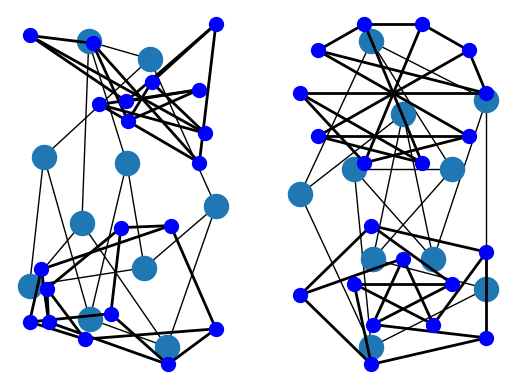

In [9]:
import matplotlib.pyplot as plt
import networkx as nx
G = nx.petersen_graph()
plt.subplot(121)
nx.draw(G, with_labels=False, font_weight='bold')
plt.subplot(122)
nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=False, font_weight='bold')

options = {
   'node_color': 'blue',
   'node_size': 100,
   'width': 2,
}
plt.subplot(221)
nx.draw_random(G, **options)
plt.subplot(222)
nx.draw_circular(G, **options)
plt.subplot(223)
nx.draw_spectral(G, **options)
plt.subplot(224)
nx.draw_shell(G, nlist=[range(5,10), range(5)], **options)

# 🖼️ Code Analysis: Image Segmentation via Spectral Clustering

The provided code implements **Spectral Clustering**, which relies on the **eigenvectors** of a matrix (derived from the Graph Laplacian) to perform dimensionality reduction before clustering.

---

## 1. Graph Construction (The "Graph Laplacian" Foundation) 🏗️

The initial steps convert the image data into a graph structure suitable for spectral analysis.

| Code Line(s) | Idea | Explanation |
| :--- | :--- | :--- |
| `img = resize(img, (re_size, re_size))` | **Image Data** | Resizes the input image (pixels are nodes). The resulting matrix is $64 \times 64$. |
| `graph = img_to_graph(img, mask=mask)` | **Adjacency Matrix ($\mathbf{A}$)** | Converts the image into a sparse graph where each pixel is a node. Edges exist between neighboring pixels. The initial edge weights are the **difference in pixel intensity (gradient)**. |
| `graph.data = np.exp(-graph.data / graph.data.std())` | **Affinity Matrix (Similarity)** | **Crucial Step:** It transforms the initial weights (differences/gradients) into **similarity/affinity scores**. If two pixels are very similar (small difference), the weight is close to $e^0 \approx 1$ (high affinity). If they are very different (large difference), the weight is close to $0$ (low affinity). This matrix is mathematically related to the $\mathbf{A}$ matrix used in the Normalized Laplacian ($\mathbf{L}_{\text{norm}}$). |

---

## 2. Spectral Decomposition (Eigenvalues and Eigenvectors) 🔢

The core theory is applied inside the `spectral_clustering` function:

* **Implicit Laplacian:** This function internally constructs a version of the **Graph Laplacian** ($\mathbf{L}$ or $\mathbf{L}_{\text{norm}}$) from the weighted affinity matrix (`graph`).
* **Eigenvalue Calculation:** It calculates the **eigenvectors** corresponding to the **$k$ smallest non-zero eigenvalues** (where $k = n\_clusters - 1 = 2$).
* **Why the smallest non-zero?** These eigenvalues correspond to the smoothest, most stable patterns that still contain some variation. These are the patterns that best separate the graph into well-connected components.
* **Eigenvector Embedding:** These few eigenvectors are used to project the data (the nodes/pixels) into a **low-dimensional space**.

---

## 3. Clustering and Segmentation

The final steps leverage the reduced, embedded space to perform the actual segmentation.

| Code Line(s) | Idea | Explanation |
| :--- | :--- | :--- |
| `labels = spectral_clustering(graph, n_clusters=3)` | **Partitioning** | The algorithm performs **k-means clustering** on the low-dimensional embedding created by the eigenvectors. The result is a set of labels ($\{0, 1, 2\}$) that partitions the $64 \times 64$ pixels into 3 connected components (segments). |
| `label_im[mask] = labels` | **Visualization** | Re-maps the labels back onto the original $64 \times 64$ image grid for visualization, showing the segmented regions. |

## Conclusion

The code connects to the theory by demonstrating that the graph's structure (how pixels are connected) is encoded in a matrix (the affinity matrix, a component of the Laplacian). By analyzing the matrix's **eigenvectors**, we can discover the optimal way to **partition the graph's nodes** (the image pixels) into highly cohesive, non-overlapping groups.

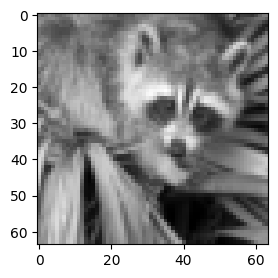

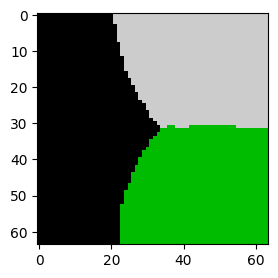

In [10]:
import numpy as np
from scipy import datasets # Corrected import
from skimage.transform import resize
import matplotlib.pyplot as plt
from numpy import linalg as LA
from scipy.sparse import csgraph
from sklearn.feature_extraction.image import img_to_graph
from sklearn.cluster import spectral_clustering
# import scipy.misc # Not needed anymore


re_size = 64 # ownsampling of resized rectangular image

# *** Correction is here: use datasets.face instead of misc.face ***
img = datasets.face(gray=True)  #retrieve a grayscale image
# ***************************************************************

img = resize(img, (re_size, re_size))
mask = img.astype(bool)
graph = img_to_graph(img, mask=mask)
#Take a decreasing function of the gradient: we take it weakly
#dependant from the gradient the segmentation is close to a voronoi
graph.data = np.exp(-graph.data / graph.data.std())
labels = spectral_clustering(graph, n_clusters=3)
label_im = -np.ones(mask.shape)
label_im[mask] = labels

plt.figure(figsize=(6, 3))
plt.imshow(img, cmap='gray', interpolation='nearest')

plt.figure(figsize=(6, 3))
plt.imshow(label_im, cmap=plt.cm.nipy_spectral, interpolation='nearest')
plt.show()

# Storing Sparse Graph Data

In [11]:
import numpy as np
import scipy.sparse as sparse
row =  np.array([0, 3, 1, 0])
col =   np.array([0, 3, 1, 2])
data = np.array([4, 5, 7, 9])

mtx = sparse.coo_matrix((data, (row, col)), shape=(4, 4))    
mtx.todense()

matrix([[4, 0, 9, 0],
        [0, 7, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 5]])

# Type of Graph Tasks:

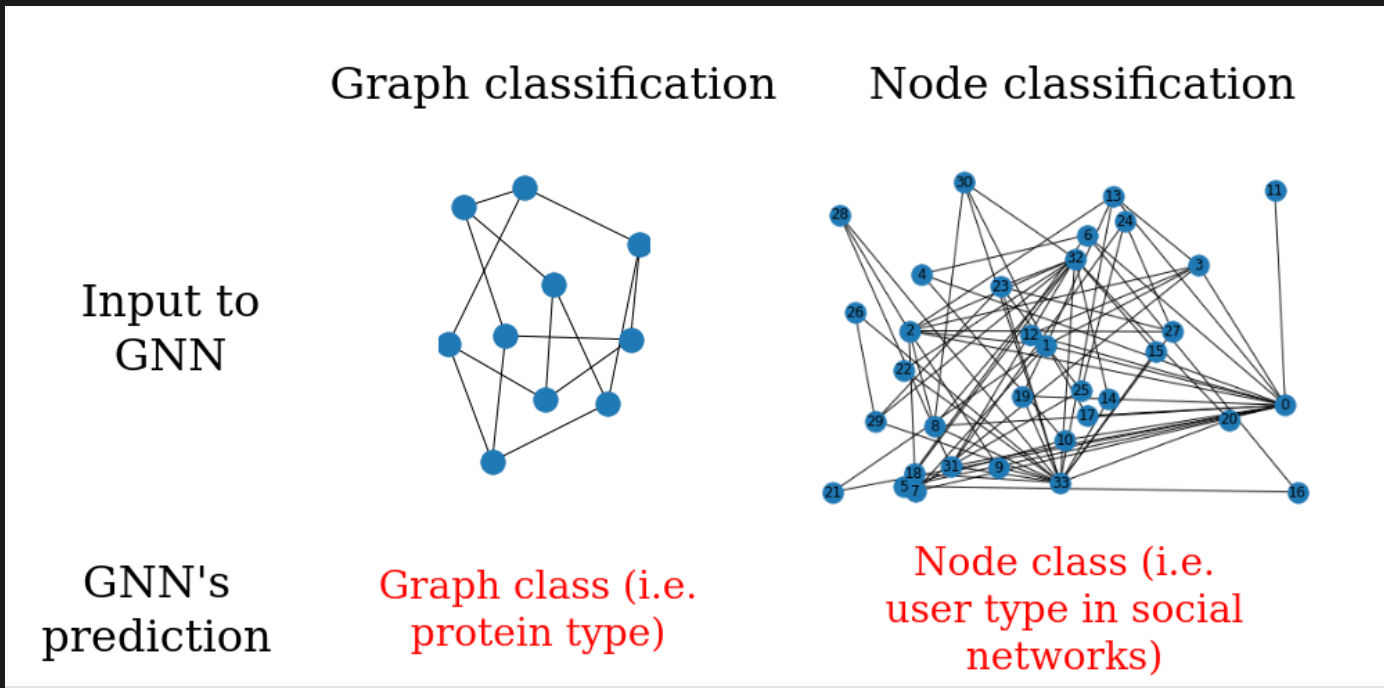